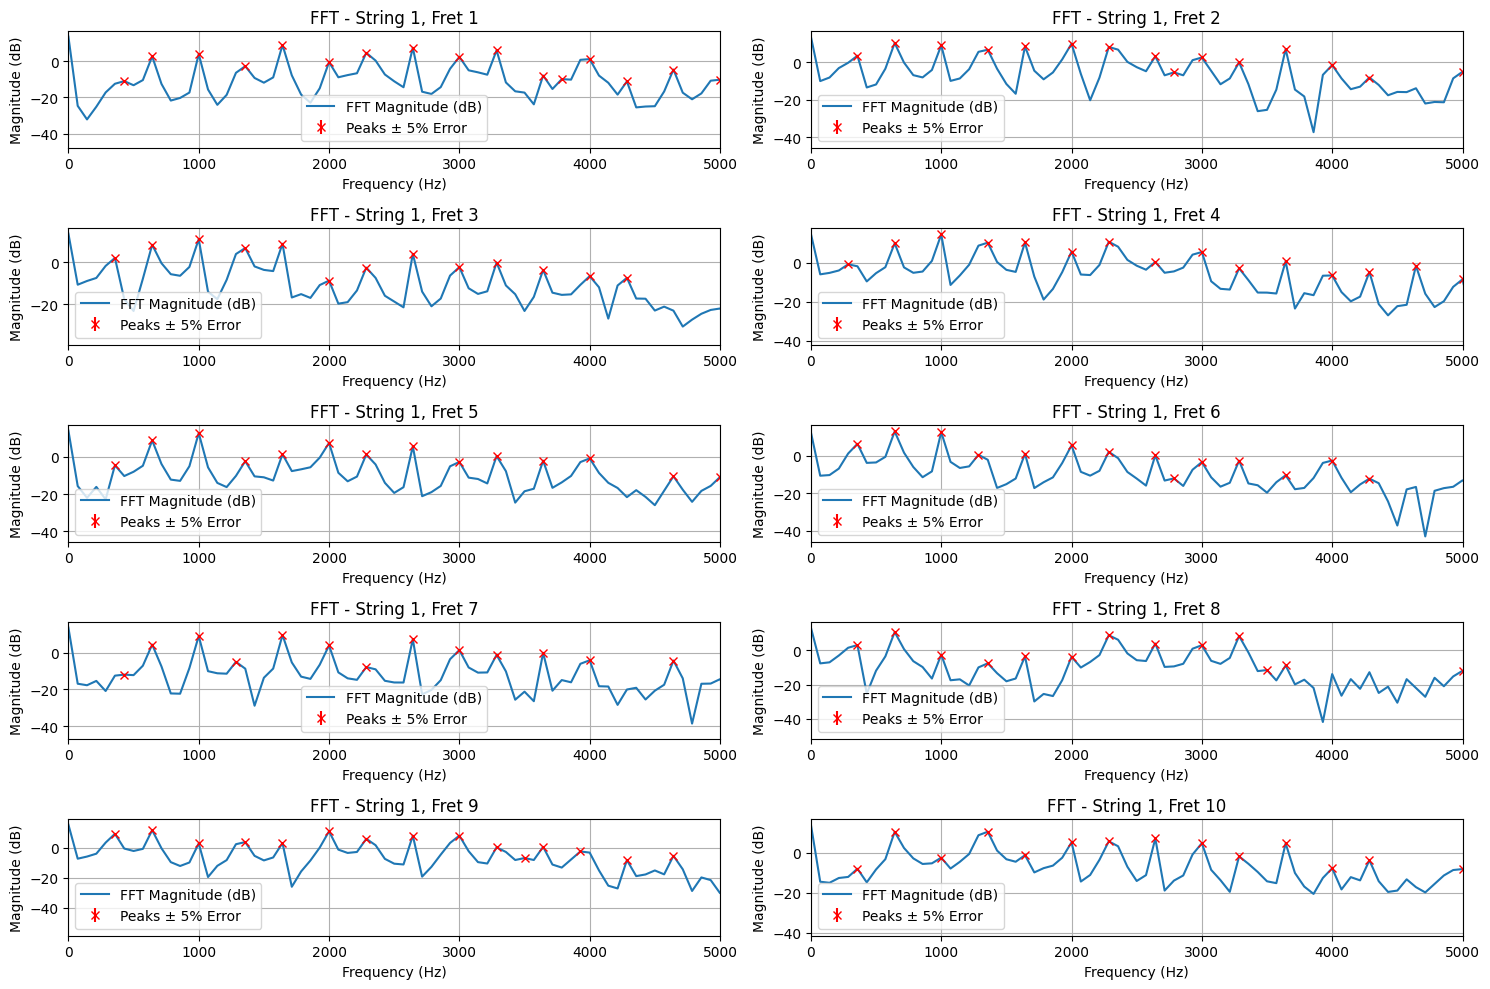

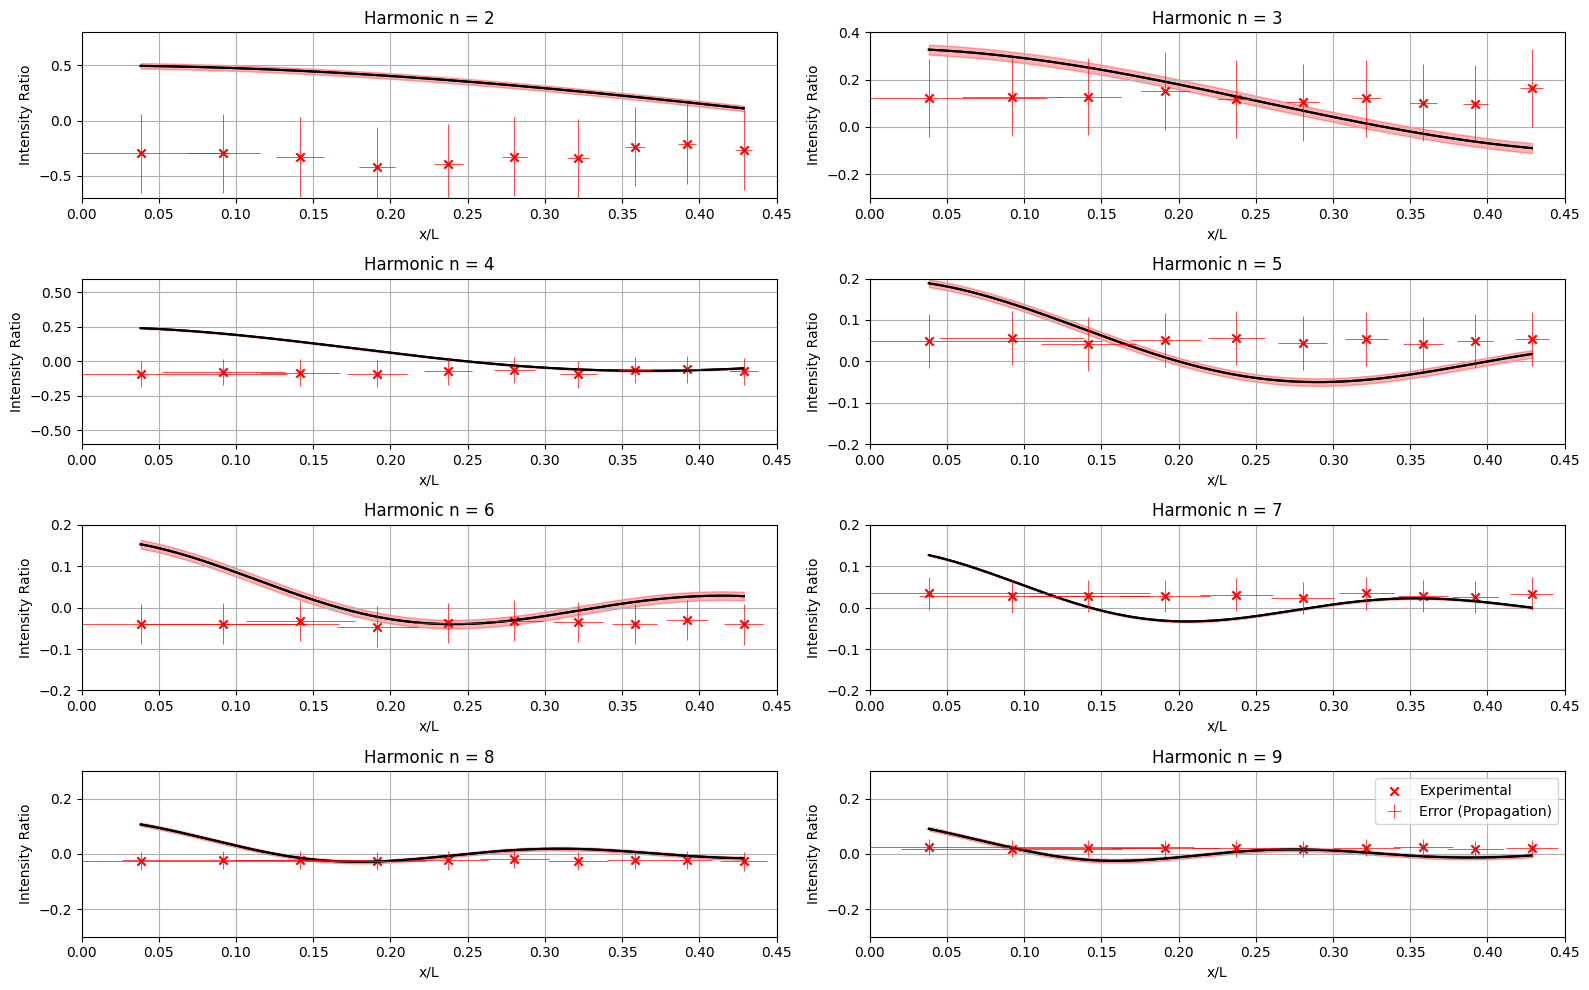

data!!! 1 Power_divergenceResult(statistic=np.float64(0.036446029666676705), pvalue=np.float64(0.999835964303171))
data!!! 2 Power_divergenceResult(statistic=np.float64(0.03211287335564514), pvalue=np.float64(0.9998724669800093))
data!!! 3 Power_divergenceResult(statistic=np.float64(0.043471551740958875), pvalue=np.float64(0.9997671732628525))
data!!! 4 Power_divergenceResult(statistic=np.float64(0.193748329737112), pvalue=np.float64(0.99560000987491))
data!!! 5 Power_divergenceResult(statistic=np.float64(0.17801270582422268), pvalue=np.float64(0.9962663123436764))
data!!! 6 Power_divergenceResult(statistic=np.float64(0.19233477495315046), pvalue=np.float64(0.9956619518195851))
data!!! 7 Power_divergenceResult(statistic=np.float64(0.048025487252184536), pvalue=np.float64(0.999716268120647))
data!!! 8 Power_divergenceResult(statistic=np.float64(0.07792666292246739), pvalue=np.float64(0.9992603615554331))
data!!! 9 Power_divergenceResult(statistic=np.float64(0.08577301713051569), pvalue=

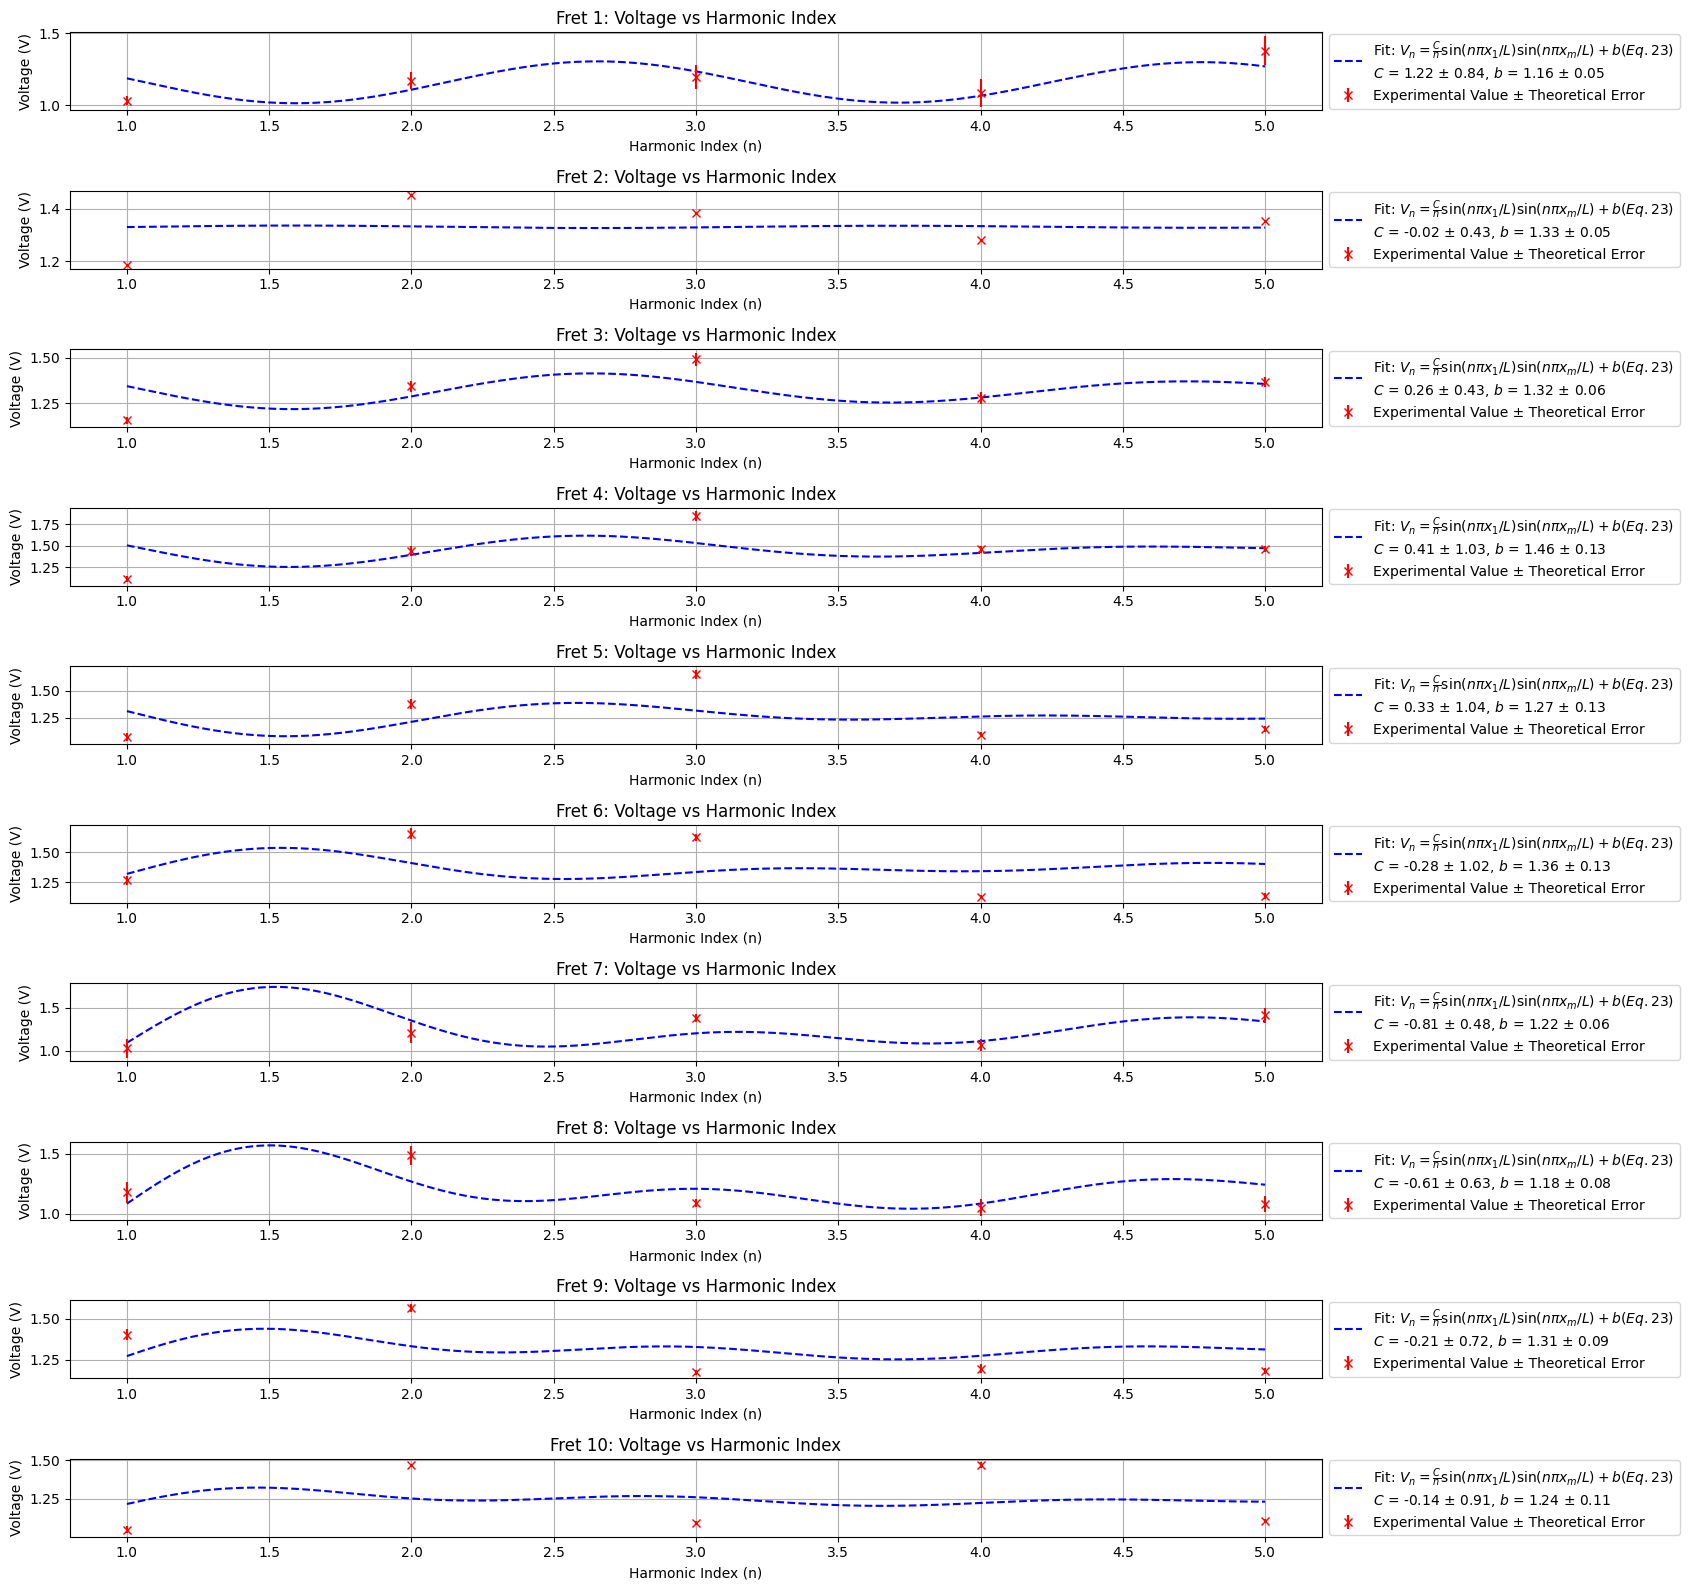

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import make_interp_spline
from numpy import sin 
from numpy import cos
from scipy.optimize import curve_fit
from scipy.stats import chisquare, goodness_of_fit


file_list= {1: ['11.csv', '12.csv'], 
                2: ['21.csv', '22.csv'],
                3: ['31.csv', '32.csv'], 
                4: ['41.csv', '42.csv'], 
                5: ['51.csv', '52.csv'], 
                6: ['61.csv', '62.csv'], 
                7: ['71.csv', '72.csv'], 
                8: ['81.csv', '82.csv'], 
                9: ['91.csv', '92.csv'],
                10: ['101.csv', '102.csv']}

distances = {1: (0.025, 0.038284),
             2: (0.06, 0.0918836),
             3: (0.0925, 0.14165390),
             4: (0.125, 0.19142419),
             5: (0.155, 0.237366),
             6: (0.183, 0.280245),
             7: (0.21, 0.3215926),
             8: (0.234, 0.358346),
             9: (0.256, 0.3920367),
             10: (0.28, 0.4287901)}

x_m = 0.615
L = 0.653
dt = 10**-5
expected_f0 = 330
frequency = 1 / dt
sensitivity = 0.05
tolerance = 100

x_over_L = [x[1] for x in distances.values()]

def read_and_average_signals(file_list):
    signals = []
    for filename in file_list:
        try:
            data = np.loadtxt(filename, delimiter=',', skiprows=2, usecols=1)
            signals.append(data)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
    return np.mean(signals, axis=0) if signals else np.array([])


def get_fft_and_peaks(signal, dt, sensitivity):
    N = len(signal)
    freq = np.fft.rfftfreq(N, dt)
    fft_result = np.fft.rfft(signal)
    magnitude = np.abs(fft_result)
    magnitude_db = 20 * np.log10(np.abs(fft_result) + 1e-12)
    peaks, _ = find_peaks(magnitude, height=np.max(magnitude) * 0.05, distance=2)
    return freq, magnitude, magnitude_db, peaks


def clean_harmonics(peaks, expected_f0, tolerance):
    freqs, mags = zip(*peaks)
    harmonics = []
    for n in range(1, 11):
        target_freq = expected_f0 * n
        diffs = np.abs(np.array(freqs) - target_freq)
        if np.min(diffs) < tolerance:
            idx = np.argmin(diffs)
            harmonics.append((freqs[idx], mags[idx]))
        else:
            harmonics.append((target_freq, 0.0))
    return harmonics


def plot_fft_all_frets(peak_data):
    fig, axs = plt.subplots(5, 2, figsize=(15, 10))
    
    for fret in file_list:
        row, col = (fret - 1) // 2, (fret - 1) % 2
        avg_signal = read_and_average_signals(file_list[fret])
        freq, mag, mag_db, peaks = get_fft_and_peaks(avg_signal, dt, sensitivity)
        peak_freqs = freq[peaks]
        peak_mags = mag[peaks]
        sorted_idx = np.argsort(peak_freqs)
        peak_freqs, peak_mags = peak_freqs[sorted_idx], peak_mags[sorted_idx]

        peak_data[fret] = list(zip(peak_freqs, peak_mags))

        axs[row, col].plot(freq, mag_db, label='FFT Magnitude (dB)')

        # Ensure peak_mags is not empty before proceeding
        if peak_mags.size > 0:
            peak_errors = 0.05 * peak_mags
            peak_mags_db = 20 * np.log10(peak_mags + 1e-12) # Added epsilon for safety
            # Propagate error to dB scale correctly
            peak_errors_db = (20 / np.log(10)) * (peak_errors / peak_mags) if np.all(peak_mags > 0) else 0

            axs[row, col].errorbar(peak_freqs, peak_mags_db, yerr=peak_errors_db, fmt='x', color='red', label='Peaks ± 5% Error')

        axs[row, col].set_title(f"FFT - String 1, Fret {fret}")
        axs[row, col].set_xlabel("Frequency (Hz)")
        axs[row, col].set_ylabel("Magnitude (dB)")
        axs[row, col].grid(True)
        
        # --- THIS IS THE ADDED LINE ---
        axs[row, col].set_xlim([0, 5000]) # Set the x-axis (frequency) limit to 5000 Hz
        # -----------------------------

        axs[row, col].legend()

    plt.tight_layout()
    plt.savefig("Fourier_transform.png")
    # plt.show() # You might want to comment this out if you're running the whole script

def plot_harmonic_intensity_ratio(cleaned_data):

    ratios = np.zeros((11,10))

    for fret in cleaned_peak_data.keys():
        #print(f"Cleaned Fret {fret}:")
        i = 0
        for freq, mag in cleaned_peak_data[fret]:
            #print(f"  Frequency: {freq:.3f} Hz, Magnitude: {mag:.3f} dB")
            ratios[fret][i] = mag
            i+=1
    
    x_values = [x[1] for x in distances.values()]  # x/L valuesy_values = []
    x_values_doi =  [x[0] for x in distances.values()]
    y_values = []

    fig, axs = plt.subplots(4, 2, figsize=(16, 10))
    
    s=0

    for n in range(2, 10):
        y_values_t = [np.sin(n * np.pi * x) / (n**2 * np.sin(np.pi * x)) for x in x_values]

        # Experimental values
        y_values_e = []

        erroare_int_osc = 1 *(np.sqrt(2)) #de schimbat!!! 
        ratie_B_V = sin(np.pi * x_m /L) / (n * sin(np.pi * n * x_m/L))
        ratie_B_x_m = []
        ratie_B_L= []
                                        
        for fret in range(1, 3):
            
            B_V_1 = ratios[fret][0]
            B_V_n = ratios[fret][n]
        # print(peaks)
            Vn_V1 = 10 ** ((B_V_n - B_V_1) / 20)
            factor_2 = (1 / n) * (np.sin(np.pi * x_m / L) / np.sin(n * np.pi * x_m / L))
            Bn_B1 = Vn_V1 * factor_2
            ratie_B_x_m.append(Vn_V1 * np.pi / (n *L * ((sin(n *np.pi * x_m/L))**2 )) * (cos(np.pi *x_m /L)* sin(n* np.pi *x_m /L) - n* sin(np.pi *x_m /L) * cos(np.pi*n  *x_m /L)) )
            ratie_B_L.append(- Vn_V1 * np.pi * x_m / (n *(L**2) * ((sin(n *np.pi * x_m/L))**2 )) * (cos(np.pi *x_m /L)* sin(n* np.pi *x_m /L) - n* sin(np.pi *x_m /L) * cos(np.pi*n  *x_m /L)) )
            y_values_e.append(Bn_B1)

        #y_values_e.append(0)
            
        for fret in range(3, 9):    
            B_V_1 = ratios[fret][0]
            B_V_n = ratios[fret][n]
        #print(peaks)
            Vn_V1 = 10 ** ((B_V_n - B_V_1) / 20)
            factor_2 = (1 / n) * (np.sin(np.pi * x_m / L) / np.sin(n * np.pi * x_m / L))
            Bn_B1 = Vn_V1 * factor_2
            ratie_B_x_m.append(Vn_V1 * np.pi / (n *(L**2) * ((sin(n *np.pi * x_m/L))**2 )) * (cos(np.pi *x_m /L)* sin(n* np.pi *x_m /L) - n* sin(np.pi *x_m /L) * cos(np.pi*n  *x_m /L)) )
            ratie_B_L.append(- Vn_V1 * np.pi * x_m / (n *(L**2) * ((sin(n *np.pi * x_m/L))**2 )) * (cos(np.pi *x_m /L)* sin(n* np.pi *x_m /L) - n* sin(np.pi *x_m /L) * cos(np.pi*n  *x_m /L)) )
            y_values_e.append(Bn_B1)
            
        #y_values_e.append(0)
        #ratie_B_x_m.append(0)
        #ratie_B_L.append(0)
        #y_values_e.append(0)
        #print(y_values_e[-1])
        for fret in range(9, 11):
            
            B_V_1 = ratios[fret][0]
            B_V_n = ratios[fret][n]
        # print(peaks)
            Vn_V1 = 10 ** ((B_V_n - B_V_1) / 20)
            factor_2 = (1 / n) * (np.sin(np.pi * x_m / L) / np.sin(n * np.pi * x_m / L))
            Bn_B1 = Vn_V1 * factor_2
            ratie_B_x_m.append(Vn_V1 * np.pi / (n *(L**2) * ((sin(n *np.pi * x_m/L))**2 )) * (cos(np.pi *x_m /L)* sin(n* np.pi *x_m /L) - n* sin(np.pi *x_m /L) * cos(np.pi*n  *x_m /L)) )
            ratie_B_L.append(- Vn_V1 * np.pi * x_m / (n *(L**2) * ((sin(n *np.pi * x_m/L))**2 )) * (cos(np.pi *x_m /L)* sin(n* np.pi *x_m /L) - n* sin(np.pi *x_m /L) * cos(np.pi*n  *x_m /L)) )
            y_values_e.append(Bn_B1)
        
        row = (n - 2) // 2
        col = (n - 2) % 2

        x_smooth = np.linspace(min(x_values), max(x_values), 300)  # More points for a smooth curve
        spline = make_interp_spline(x_values, y_values_t)
        y_smooth = spline(x_smooth)

        errors_x = np.zeros(len(x_values))
        errors_y = np.zeros(len(x_values))
        
        #aici facem erorile
        
        for n_ind in range(len(x_values)):
            errors_x[n_ind] = x_values[n] * np.sqrt(( 0.01 / x_values_doi[n_ind] )**2 +(0.01 / L)**2)
            errors_y[n_ind] = np.sqrt( (erroare_int_osc * ratie_B_V )**2 + (0.01 *  ratie_B_x_m[n_ind]  )**2 + (0.01 *  ratie_B_L[n_ind])**2 )   

        for t in range(len(x_smooth)):
            error_th = np.sqrt( (0.01 * ((1/n)**2) *(cos(n* np.pi * x_smooth[t]/L) * n *np.pi /L * sin(np.pi* x_smooth[t] /L) - sin(n* np.pi * x_smooth[t]/L)* cos(np.pi* x_smooth[t] /L)* np.pi/L  ) /  (sin(np.pi* x_smooth[t] /L)**2)  )**2 + (0.01 * ((1/n)**2) *(- cos(n* np.pi * x_smooth[t]/L) * n *np.pi*x_smooth[t] /(L**2) * sin(np.pi* x_smooth[t] /L) + sin(n* np.pi * x_smooth[t]/L)* cos(np.pi* x_smooth[t] /L)* np.pi *x_smooth[t]/(L**2)  ) /  (sin(np.pi* x_smooth[t] /L)**2)  )**2    )

        #s+=(errors_y[1])
        #s=0
        #p=0
        #for i in range(len(y_values_e)):
        #    s = s +np.abs(y_smooth[i*30]-y_values_e[i])
        #print(s/10)
        

        axs[row, col].plot(x_smooth, (y_smooth), color='black')
        axs[row, col].plot(x_smooth, (y_smooth), color= 'red', alpha=0.3, linewidth=error_th)
        #axs[row, col].plot(x_smooth + error_th, (y_smooth), color= 'green' )
        
        axs[row, col].fill_between(x_smooth,  (y_smooth)+ error_th, y_smooth - error_th, alpha=0.3, color= 'red')
        axs[row, col].plot(x_smooth, (y_smooth), color='black')
        
        axs[row, col].scatter(x_values, (np.array(y_values_e)), color='red', label="Experimental", marker='x')
        axs[row, col].errorbar(x_values, (np.array(y_values_e)), xerr= errors_x, yerr = errors_y, color='red', label="Error (Propagation)", linestyle='None', elinewidth=0.5)
        axs[row, col].set_title(f"Harmonic n = {n}")
        axs[row, col].set_xlabel("x/L")
        axs[row, col].set_ylabel("Intensity Ratio")
        axs[row, col].set_xlim((0,0.45))
        axs[row, col].set_ylim((-0.2,0.2))
        axs[row, col].grid(True)

        axs[0, 0].set_ylim((-0.7,0.8))
        axs[1, 0].set_ylim((-0.6,0.6))
        axs[0, 1].set_ylim((-0.3,0.4))
        axs[3, 0].set_ylim((-0.3,0.3))
        axs[3, 1].set_ylim((-0.3,0.3))

    plt.tight_layout()
    plt.legend()
    plt.savefig("Intensity_ratio.png")
    plt.show()


def plot_voltage_vs_frequency_with_theory(cleaned_data, L=0.653, x_m=0.615, delta_L=0.003, delta_xm=0.002, delta_x1=0.002):
    fig, axs = plt.subplots(10, 1, figsize=(17, 16))
    axs = axs.flatten()
    fret_to_x1_cm = {1: 2.5, 2: 6.0, 3: 9.25, 4: 12.5, 5: 15.5,
                     6: 18.3, 7: 21.0, 8: 23.4, 9: 25.6, 10: 28.0}
    for fret in range(1, 11):
        ax = axs[fret - 1]
        x1 = fret_to_x1_cm[fret] / 100
        if len(cleaned_data[fret]) < 5:
            print(f"Warning: Fret {fret} has less than 5 harmonics. Using all available.")
            freqs, mags_dB = zip(*cleaned_data[fret])
        else:
            freqs, mags_dB = zip(*cleaned_data[fret][:5])
        voltages = [10 ** (mag / 20) for mag in mags_dB]
        harmonic_indices = np.array(range(1, len(voltages) + 1))
        voltages = np.array(voltages)
        valid = voltages > 1e-9
        harmonic_indices = harmonic_indices[valid]
        voltages = voltages[valid]

        def model(n, C, b):
            return (C / n) * np.sin(n * np.pi * x1 / L) * np.sin(n * np.pi * x_m / L) + b

        C_fit, b_fit = np.nan, np.nan
        try:
            popt, pcov = curve_fit(model, harmonic_indices, voltages, p0=(1, 0), maxfev=10000)
            error_C, error_b = np.sqrt(np.diag(pcov))
            C_fit, b_fit = popt
            n_smooth = np.linspace(1, len(voltages), 500)
            Vn_fit_smooth = model(n_smooth, C_fit, b_fit)
            ax.plot(n_smooth, Vn_fit_smooth, color='blue', linestyle='--', label=(
                r"Fit: $V_n = \frac{C}{n}\sin(n\pi x_1/L)\sin(n\pi x_m/L) + b (Eq. 23)$"
                f"\n$C$ = {C_fit:.2f} ± {error_C:.2f}, $b$ = {b_fit:.2f} ± {error_b:.2f}"))
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Fit failed\n{e}", transform=ax.transAxes, ha='center', va='center', color='gray')

        theory_errors_at_exp = []
        if not np.isnan(C_fit) and not np.isnan(b_fit):
            for n_exp in harmonic_indices:
                A = n_exp * np.pi * x1 / L
                B = n_exp * np.pi * x_m / L
                dV_dx1 = ( 10 *C_fit * np.pi / L) * np.cos(A) * np.sin(B)
                dV_dxm = ( 10 *C_fit * np.pi / L) * np.sin(A) * np.cos(B)
                dV_dL = -( 10 *C_fit * np.pi / (L**2)) * (x1 * np.cos(A) * np.sin(B) + x_m * np.sin(A) * np.cos(B))
                error_sq = (dV_dx1 * delta_x1)**2 + (dV_dxm * delta_xm)**2 + (dV_dL * delta_L)**2
                theory_errors_at_exp.append(np.sqrt(error_sq))
        
        if len(harmonic_indices) > 0:
            if len(theory_errors_at_exp) == len(harmonic_indices):
                ax.errorbar(harmonic_indices, voltages, yerr=theory_errors_at_exp, fmt='x', color='red', label='Experimental Value ± Theoretical Error')

            else:
                ax.scatter(harmonic_indices, voltages, color='red', marker='x', label="Experimental (Error calc failed)")

        else:
            ax.text(0.5, 0.5, "No valid experimental data points", transform=ax.transAxes, ha='center', va='center', color='gray')


        obs_data= model(np.array([1, 2, 3, 4, 5]), C_fit, b_fit)
        
        
    #goodness_of_fit(dist, data, known_params=None, fit_params=None, guessed_params=None, statistic='ad', n_mc_samples=9999, rng=None)[source]
    #try:

# Calculate chi-squared statistic for goodness-of-fit
        obs_data = model(np.array([1, 2, 3, 4, 5]), C_fit, b_fit)
        print(f"data!!! {fret}", chisquare(obs_data, voltages))
        ax.set_title(f"Fret {fret}: Voltage vs Harmonic Index")
        ax.set_xlabel("Harmonic Index (n)")
        ax.set_ylabel("Voltage (V)")
        ax.grid(True)
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    #handles, labels = ax.get_legend_handles_labels()
    #fig.legend(handles = , labels, loc='lower right')
    #fig.legend(handles=[line2], loc='lower right')

    #ax.set_ylim(top=1)
    plt.tight_layout()
    plt.savefig("Voltage_vs_frequency.png")
    plt.show()


# MAIN SCRIPT
peak_data = {}
plot_fft_all_frets(peak_data)
'''
for fret in peak_data:
    print(f"\nFret {fret}:")
    for freq, mag in peak_data[fret]:
        print(f"  Frequency: {freq:.2f} Hz, Magnitude: {mag:.2f} V")'''

cleaned_peak_data = {fret: clean_harmonics(peaks, expected_f0, tolerance) for fret, peaks in peak_data.items()}
'''
for fret in cleaned_peak_data:
    print(f"\nCleaned Fret {fret}:")
    for f, m in cleaned_peak_data[fret]:
        print(f"  Frequency: {f:.2f} Hz, Magnitude: {m:.2f} V")'''

plot_harmonic_intensity_ratio(cleaned_peak_data)

delta_L = 0.03
delta_xm = 0.03
delta_x1 = 0.03
plot_voltage_vs_frequency_with_theory(cleaned_peak_data)